# Summary

Generate adjancency matrices for the Protherm training set directly from PDBs.

---

# Imports

In [79]:
import logging
import os
import os.path as op
import shutil
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import tqdm

import kmbio.PDB

In [77]:
%matplotlib inline

In [48]:
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

# Parameters

In [4]:
NOTEBOOK_NAME = 'protherm_dataset'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)

NOTEBOOK_PATH.mkdir(parents=True, exist_ok=True)

In [7]:
DATABIN_PATH = Path(os.environ['DATABIN_DIR'])

# Load data

In [11]:
ROSETTA_RESULTS = {}

with pd.HDFStore(DATABIN_PATH.joinpath('elapsam_feature_engineering/v0.1.0/rosetta.h5').as_posix(), 'r') as store:
    for key in store:
        ROSETTA_RESULTS[key.strip('/')] = store[key][:]

In [12]:
ROSETTA_RESULTS.keys()

dict_keys(['cartesian_ddg-beta_nov15_cart-1', 'cartesian_ddg-beta_nov16_cart-1', 'cartesian_ddg-score12_cart-1', 'cartesian_ddg-talaris2013_cart-1', 'cartesian_ddg-talaris2014_cart-1', 'ddg_monomer-soft_rep_design-1'])

In [13]:
ROSETTA_RESULTS['cartesian_ddg-talaris2014_cart-1'].head()

,filename-wt,pdb_chain,mutation,ddg,ddg_exp
Index,,,,,
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-0.633667,-0.53
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,-0.188000,-0.20
2,/home/kimlab2/database_data/biological-data-wa...,A,A116N,0.114000,0.17
3,/home/kimlab2/database_data/biological-data-wa...,A,A122Q,0.508667,-0.24
4,/home/kimlab2/database_data/biological-data-wa...,A,A123Q,-0.577667,-0.22


In [14]:
rosetta_results_df = None

for key, df in ROSETTA_RESULTS.items():
    df = df.rename(columns={'ddg': key})
    if rosetta_results_df is None:
        rosetta_results_df = df
    else:
        assert (rosetta_results_df['ddg_exp'].values == df['ddg_exp'].values).all()
        rosetta_results_df = rosetta_results_df.merge(
            df.drop('ddg_exp', axis=1), on=['filename-wt', 'pdb_chain', 'mutation'], how='outer')
    
display(rosetta_results_df.head())
print(rosetta_results_df.shape)

,filename-wt,pdb_chain,mutation,cartesian_ddg-beta_nov15_cart-1,ddg_exp,cartesian_ddg-beta_nov16_cart-1,cartesian_ddg-score12_cart-1,cartesian_ddg-talaris2013_cart-1,cartesian_ddg-talaris2014_cart-1,ddg_monomer-soft_rep_design-1
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701000,0.088000,-0.289667,-0.633667,-2.384
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354000,0.560000,-0.069000,-0.188000,2.472
2,/home/kimlab2/database_data/biological-data-wa...,A,A116N,0.502667,0.17,-0.131333,0.419000,0.392000,0.114000,0.652
3,/home/kimlab2/database_data/biological-data-wa...,A,A122Q,1.760333,-0.24,1.999000,3.205667,0.605667,0.508667,12.540
4,/home/kimlab2/database_data/biological-data-wa...,A,A123Q,0.110333,-0.22,-1.153000,1.313000,-0.334333,-0.577667,-3.730


(3471, 10)


## Copy structures

In [28]:
STRUCTURE_PATH = NOTEBOOK_PATH.joinpath('structures')
STRUCTURE_PATH.mkdir(exist_ok=True)

In [29]:
# for file in STRUCTURE_PATH.glob('*'):
#     os.remove(file)

In [30]:
os.listdir(STRUCTURE_PATH)

[]

In [31]:
def get_local_filename(filename):
    return STRUCTURE_PATH.joinpath(op.basename(filename)).absolute().as_posix()

get_local_filename(rosetta_results_df['filename-wt'].iloc[0])

'/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/protherm_dataset/structures/pdb107l.entA_0--G44S-wt.pdb'

In [32]:
file_list

['/home/kimlab2/database_data/biological-data-warehouse/elapsam_feature_engineering/notebooks/elaspic_standalone/protherm_star_2/107l/.elaspic/model/mutations/pdb107l.entA_0--G44S/pdb107l.entA_0--G44S-wt.pdb',
 '/home/kimlab2/database_data/biological-data-warehouse/elapsam_feature_engineering/notebooks/elaspic_standalone/protherm_star_2/160l/.elaspic/model/mutations/pdb160l.entA_0--A120M/pdb160l.entA_0--A120M-wt.pdb',
 '/home/kimlab2/database_data/biological-data-warehouse/elapsam_feature_engineering/notebooks/elaspic_standalone/protherm_star_2/161l/.elaspic/model/mutations/pdb161l.entA_0--A116N/pdb161l.entA_0--A116N-wt.pdb',
 '/home/kimlab2/database_data/biological-data-warehouse/elapsam_feature_engineering/notebooks/elaspic_standalone/protherm_star_2/162l/.elaspic/model/mutations/pdb162l.entA_0--A122Q/pdb162l.entA_0--A122Q-wt.pdb',
 '/home/kimlab2/database_data/biological-data-warehouse/elapsam_feature_engineering/notebooks/elaspic_standalone/protherm_star_2/163l/.elaspic/model/mutat

In [35]:
file_list = rosetta_results_df['filename-wt'].drop_duplicates().tolist()

for filename in tqdm.tqdm_notebook(file_list, total=len(file_list)):
    new_filename = STRUCTURE_PATH.joinpath(op.basename(filename))
    filename = filename.replace(
        "/home/kimlab2/database_data/biological-data-warehouse",
        Path("~/datapkg").expanduser().as_posix(),
    )
    shutil.copy(filename, get_local_filename(filename))

rosetta_results_df['local-filename-wt'] = rosetta_results_df['filename-wt'].apply(get_local_filename)

HBox(children=(IntProgress(value=0, max=3471), HTML(value='')))

# Process data

## Extract adjacencies

In [43]:
from kmtools import structure_tools


def get_interaction_dataset(structure_file, R_CUTOFF):
    """Copied from "datapkg/pdb-analysis/notebooks/extract_pdb_interactions.ipynb"
    """
    try:
        structure = kmbio.PDB.load(structure_file, bioassembly_id=1, use_auth_id=False)
        bioassembly_id = 1
    except (kmbio.PDB.exceptions.BioassemblyError, KeyError) as e:
        logger.info("Could not construct bioassembly for file '%s'", structure_file)
        structure = kmbio.PDB.load(structure_file, bioassembly_id=0, use_auth_id=False)
        bioassembly_id = 0

    interactions = structure_tools.get_interactions(structure, r_cutoff=R_CUTOFF, interchain=True)
    interactions_core, interactions_interface = structure_tools.process_interactions(interactions)

    # Group interactions by chain / chan pair
    interactions_core_aggbychain = structure_tools.process_interactions_core(
        structure, interactions_core)
    interactions_interface_aggbychain = structure_tools.process_interactions_interface(
        structure, interactions_interface)

    # Drop duplicate rows?
    interactions_core, interactions_core_aggbychain = \
        structure_tools.drop_duplicates_core(interactions_core, interactions_core_aggbychain)
    interactions_interface, interactions_interface_aggbychain = \
        structure_tools.drop_duplicates_interface(interactions_interface,
                                                  interactions_interface_aggbychain)

    return (interactions_core, interactions_core_aggbychain, interactions_interface,
            interactions_interface_aggbychain, bioassembly_id)

In [44]:
kmbio.PDB.core.atom.logger.setLevel(logging.WARNING)

In [49]:
R_CUTOFF = 5

filenames = rosetta_results_df['local-filename-wt'].drop_duplicates().tolist()

adjacency_dfs = []
for filename in tqdm.tqdm_notebook(filenames, total=len(filenames)):
    df = get_interaction_dataset(filename, R_CUTOFF)[1]
    df['local-filename-wt'] = filename
    adjacency_dfs.append(df)

HBox(children=(IntProgress(value=0, max=3471), HTML(value='')))

/home/kimlab1/strokach/working/kmbio/kmbio/PDB/io/loaders.py:128: UserWarning: Not all arguments where used during the call to _get_parser! (kwargs = {'use_auth_id': False})
  f"Not all arguments where used during the call to _get_parser! (kwargs = {kwargs})"


In [50]:
adjacency_df = pd.concat(adjacency_dfs, axis=0, ignore_index=True)

In [51]:
adjacency_df['residue_idx_1_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[0] for t in lst]))
adjacency_df['residue_idx_2_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[1] for t in lst]))

In [52]:
adjacency_df = adjacency_df.drop('residue_pair', axis=1)

In [55]:
pq.write_table(
    pa.Table.from_pandas(adjacency_df, preserve_index=False),
    NOTEBOOK_PATH.joinpath('protherm_adjacencies.parquet').as_posix(),
    version='2.0', flavor='spark'
)

## Combine

In [56]:
rosetta_results_df.head(2)

,filename-wt,pdb_chain,mutation,cartesian_ddg-beta_nov15_cart-1,ddg_exp,cartesian_ddg-beta_nov16_cart-1,cartesian_ddg-score12_cart-1,cartesian_ddg-talaris2013_cart-1,cartesian_ddg-talaris2014_cart-1,ddg_monomer-soft_rep_design-1,local-filename-wt
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...


In [57]:
adjacency_df.head(2)

,structure_id,model_id,chain_id,protein_sequence,protein_sequence_hash,residue_sequence,residue_pair_hash,local-filename-wt,residue_idx_1_corrected,residue_idx_2_corrected
0,107l,0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,702F6C915C7242D7,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",b0f2bc3f2dd1e9ac1537d7124c11285b,/home/kimlab1/database_data/datapkg/adjacency-...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, ...","[1, 2, 4, 5, 8, 157, 160, 0, 2, 3, 4, 5, 157, ..."
1,160l,0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,942F635E748E4DBA,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",1d757a99b0ce97c16ec50b2eb05298a1,/home/kimlab1/database_data/datapkg/adjacency-...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 4, 5, 8, 157, 160, 0, 2, 3, 4, 5, 6, 15..."


In [58]:
protherm_validaton_dataset = (
    rosetta_results_df
    .rename(columns={'pdb_chain': 'chain_id'})
    .merge(adjacency_df, how='left', on=['local-filename-wt', 'chain_id'])
)

In [59]:
protherm_validaton_dataset.head()

,filename-wt,chain_id,mutation,cartesian_ddg-beta_nov15_cart-1,ddg_exp,cartesian_ddg-beta_nov16_cart-1,cartesian_ddg-score12_cart-1,cartesian_ddg-talaris2013_cart-1,cartesian_ddg-talaris2014_cart-1,ddg_monomer-soft_rep_design-1,local-filename-wt,structure_id,model_id,protein_sequence,protein_sequence_hash,residue_sequence,residue_pair_hash,residue_idx_1_corrected,residue_idx_2_corrected
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701000,0.088000,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,702F6C915C7242D7,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",b0f2bc3f2dd1e9ac1537d7124c11285b,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, ...","[1, 2, 4, 5, 8, 157, 160, 0, 2, 3, 4, 5, 157, ..."
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354000,0.560000,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,942F635E748E4DBA,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",1d757a99b0ce97c16ec50b2eb05298a1,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 4, 5, 8, 157, 160, 0, 2, 3, 4, 5, 6, 15..."
2,/home/kimlab2/database_data/biological-data-wa...,A,A116N,0.502667,0.17,-0.131333,0.419000,0.392000,0.114000,0.652,/home/kimlab1/database_data/datapkg/adjacency-...,161l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0F49BC9148724186,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",7e0057d9bfd050d637179e5f409cdb72,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 4, 5, 8, 157, 160, 161, 0, 2, 3, 4, 5, ..."
3,/home/kimlab2/database_data/biological-data-wa...,A,A122Q,1.760333,-0.24,1.999000,3.205667,0.605667,0.508667,12.540,/home/kimlab1/database_data/datapkg/adjacency-...,162l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,813B3DC148724DBA,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",06c025f9d9a2857eea757fd4b5c691fe,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 4, 5, 8, 157, 160, 0, 2, 3, 4, 5, 6, 15..."
4,/home/kimlab2/database_data/biological-data-wa...,A,A123Q,0.110333,-0.22,-1.153000,1.313000,-0.334333,-0.577667,-3.730,/home/kimlab1/database_data/datapkg/adjacency-...,163l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,607E3C9148724DA0,"MET,ASN,ILE,PHE,GLU,MET,LEU,ARG,ILE,ASP,GLU,GL...",18067f5788126458390e65ea0c71ffcf,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 4, 5, 8, 157, 160, 161, 0, 2, 3, 4, 5, ..."


In [60]:
assert len(rosetta_results_df) == len(protherm_validaton_dataset)

In [61]:
assert not protherm_validaton_dataset.isnull().any().any()

In [62]:
assert not any(c.endswith('_1') for c in protherm_validaton_dataset.columns)

In [63]:
def mutation_matches_sequence(mutation, sequence):
    return sequence[int(mutation[1:-1]) - 1] == mutation[0]


protherm_validaton_dataset['mutation_matches_sequence'] = (
    protherm_validaton_dataset[['mutation', 'protein_sequence']].apply(
        lambda s: mutation_matches_sequence(s.mutation, s.protein_sequence),
        axis=1)
)

assert protherm_validaton_dataset['mutation_matches_sequence'].all()

## Write

In [64]:
columns = [
    'structure_id', 'model_id', 'chain_id', 'qseq', 'qseq_mutation', 'ddg_exp', 
    'residue_idx_1_corrected', 'residue_idx_2_corrected'
]

In [65]:
df = (
    protherm_validaton_dataset
    .rename(columns={'protein_sequence': 'qseq', 'mutation': 'qseq_mutation'})
    [columns]
)

pq.write_table(
    pa.Table.from_pandas(df, preserve_index=False),
    NOTEBOOK_PATH.joinpath('protherm_validaton_dataset.parquet').as_posix(),
    version='2.0', flavor='spark'
)

# Explore

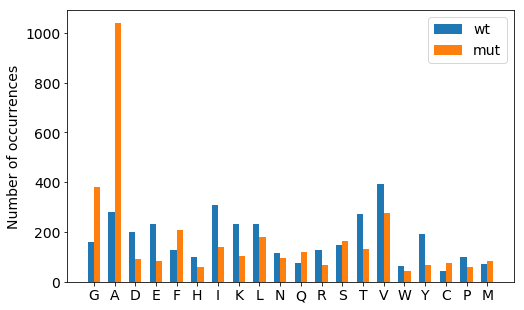

In [104]:
aa_wt_counter = Counter(protherm_validaton_dataset['mutation'].str[0])
aa_mut_counter = Counter(protherm_validaton_dataset['mutation'].str[-1])

labels = list(aa_wt_counter)
aa_wt = [aa_wt_counter[l] for l in labels]
aa_mut = [aa_mut_counter[l] for l in labels]

indexes = np.arange(len(labels))
width = 0.3

with plt.rc_context(rc={'figure.figsize': (8, 5), 'font.size': 14}):
    plt.bar(indexes - 0.15 , aa_wt, width, label="wt")
    plt.bar(indexes + 0.15, aa_mut, width, label="mut")
    plt.xticks(indexes, labels)
    plt.ylabel("Number of occurrences")
    plt.legend()